In [1]:
%pip install pylatex pandas matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd

df = pd.read_csv("measurements/new-reliable-results.csv")
df

,content_type,number_of_peers,opt_type,runtime_in_ms,success,objective,max_delay
0,VIDEO,2,DIR,0.2577,1,126.0,66.6596
1,VIDEO,2,HEU,2.5024,1,126.0,66.6596
2,VIDEO,2,ILP,935.7681,1,126.0,66.6596
3,VIDEO,2,MST,12.0208,1,126.0,66.6596
4,VIDEO,8,DIR,0.0153,1,513.0,69.8958
...,...,...,...,...,...,...,...
438,GAMING,37,HEU,19.5317,0,0.0,75.0000
439,GAMING,37,MST,14.0257,0,0.0,75.0000
440,GAMING,43,DIR,0.0427,0,0.0,75.0000
441,GAMING,43,HEU,28.6255,0,0.0,75.0000


In [2]:
MAX_PEERS = 24

opt_data_by_content = {}

# Gather data for plotting
for content_type in df["content_type"].unique():
    data = df[(df["content_type"] == content_type) & (df["number_of_peers"] <= MAX_PEERS)].sort_values(["number_of_peers"])
    print(f"Content type: {content_type}:\n{data.describe()}")

    peers = data["number_of_peers"].unique()
    dir_data = data[data["opt_type"] == "DIR"]
    heu_data = data[data["opt_type"] == "HEU"]
    ilp_data = data[data["opt_type"] == "ILP"]
    mst_data = data[data["opt_type"] == "MST"]

    # Adjust zero values in dir_data to 0.1 to avoid log(0)
    dir_data.loc[dir_data["runtime_in_ms"] <= 0.1, "runtime_in_ms"] = 0.1

    # Put data together for plotting
    opt_data = {"DIR": dir_data, "HEU": heu_data, "ILP": ilp_data, "MST": mst_data}
    opt_data_by_content[content_type] = opt_data

print("Data for plotting:")
for content_type, opt_data in opt_data_by_content.items():
    print(content_type)
    for opt_type, data in opt_data.items():
        print(f"\t{opt_type}: #{len(data)}")

Content type: VIDEO:
       number_of_peers  runtime_in_ms  success    objective   max_delay
count        84.000000   8.400000e+01     84.0    84.000000   84.000000
mean         12.285714   2.452755e+05      1.0   513.678571  103.366096
std           6.505922   9.142144e+05      0.0   426.402580   59.801165
min           2.000000   1.530000e-02      1.0   126.000000   66.659600
25%           7.000000   2.387250e-01      1.0   134.000000   73.977600
50%          12.000000   1.204655e+01      1.0   510.000000   83.751100
75%          17.250000   2.037817e+01      1.0   518.000000  115.781275
max          24.000000   6.450094e+06      1.0  1672.000000  398.407600
Content type: AUDIO:
       number_of_peers  runtime_in_ms  success    objective   max_delay
count        85.000000   8.500000e+01     85.0    85.000000   85.000000
mean         12.341176   2.805273e+05      1.0   513.647059   93.446309
std           6.487264   9.632006e+05      0.0   423.856970   23.003866
min           2.000000

In [3]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

NAMES = {
    "DIR": "Direct Link Tree",
    "HEU": "Multicast Heuristic",
    "ILP": "Integer Linear Programming",
    "MST": "Minimum Spanning Tree",
}

LATENCIES = {
    "VIDEO": 400,
    "AUDIO": 150,
    # "MESSAGING": 1000,
    "GAMING": 75,
}

def plot_runtime_vs_peers(opt_data_by_content):
    COLORED_MARKERS = [("black", "o"), ("blue", "p"), ("red", "s"), ("green", "^")]
    fontdict = {"fontsize": 14, "fontweight": "bold"}
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.size"] = 12

    col_count = 3
    row_count = (len(opt_data_by_content) + col_count - 1) // col_count

    # Create the figure and grid specification
    fig = plt.figure(figsize=(6.25 * col_count, 3 * 5.5 * row_count))
    gs = GridSpec(3 * row_count, col_count, width_ratios=[1] * col_count, figure=fig, wspace=0.2, hspace=0.15)

    for i, (content_type, opt_data) in enumerate(sorted(opt_data_by_content.items(), key=lambda x: LATENCIES[x[0]], reverse=True)):
        peers = range(2, MAX_PEERS + 1)

        # Logarithmic scale subplot
        ax = fig.add_subplot(gs[0, i])
        ax.set_title(f"D = {LATENCIES[content_type]} ms", fontdict=fontdict)
        ax.set_yscale("log")
        # ax.set_xlabel("Number of Peers", fontdict=fontdict)
        if i == 0:
            ax.set_ylabel("Runtime [ms]", fontdict=fontdict)
        ax.grid(True, which="both", linestyle="--", linewidth=0.4)
        ax.set_ylim([0.1, 1e7])
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

        # Linear scale subplot for the objective value
        ax2 = fig.add_subplot(gs[1, i])
        # ax2.set_title(f"D = {LATENCIES[content_type]} ms", fontdict=fontdict)
        ax2.set_yscale("linear")
        # ax2.set_xlabel("Number of Peers", fontdict=fontdict)
        if i == 0:
            ax2.set_ylabel("Cost [unit]", fontdict=fontdict)
        ax2.grid(True, which="both", linestyle="--", linewidth=0.4)
        ax2.set_ylim([0, 1800])
        ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

        # Linear scale subplot for the delay value
        ax3 = fig.add_subplot(gs[2, i])
        # ax3.set_title(f"D = {LATENCIES[content_type]} ms", fontdict=fontdict)
        ax3.set_yscale("linear")
        ax3.set_xlabel("Number of Peers", fontdict=fontdict, labelpad=5)
        if i == 0:
            ax3.set_ylabel("Maximum E2E delay [ms]", fontdict=fontdict)
        ax3.grid(True, which="both", linestyle="--", linewidth=0.4)
        # ax3.set_ylim([0, LATENCIES[content_type]])
        ax3.set_ylim([0, 420])
        ax3.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

        for (opt, data), (color, marker) in zip(opt_data.items(), COLORED_MARKERS):
            opt_name = NAMES[opt]
            count = min(len(data), len(peers))
            ax.plot(peers[:count], data["runtime_in_ms"].values[:count], label=opt_name, color=color, marker=marker, linewidth=1.5)
            ax2.plot(peers[:count], data["objective"].values[:count], label=opt_name, color=color, marker=marker, linewidth=1.5)
            ax3.plot(peers[:count], data["max_delay"].values[:count], label=opt_name, color=color, marker=marker, linewidth=1.5)

    # Labels from the last subplot
    handles, labels = ax.get_legend_handles_labels()
    # set minimal padding for the legend
    fig.legend(handles, labels, ncol=len(labels), loc="upper center", bbox_to_anchor=(0.5, 0.925), borderaxespad=0.01, fontsize=12)

    # Show the plot
    plt.rcParams["svg.fonttype"] = "none"
    plt.savefig("runtime_vs_peers.svg", bbox_inches="tight", pad_inches=0.1)

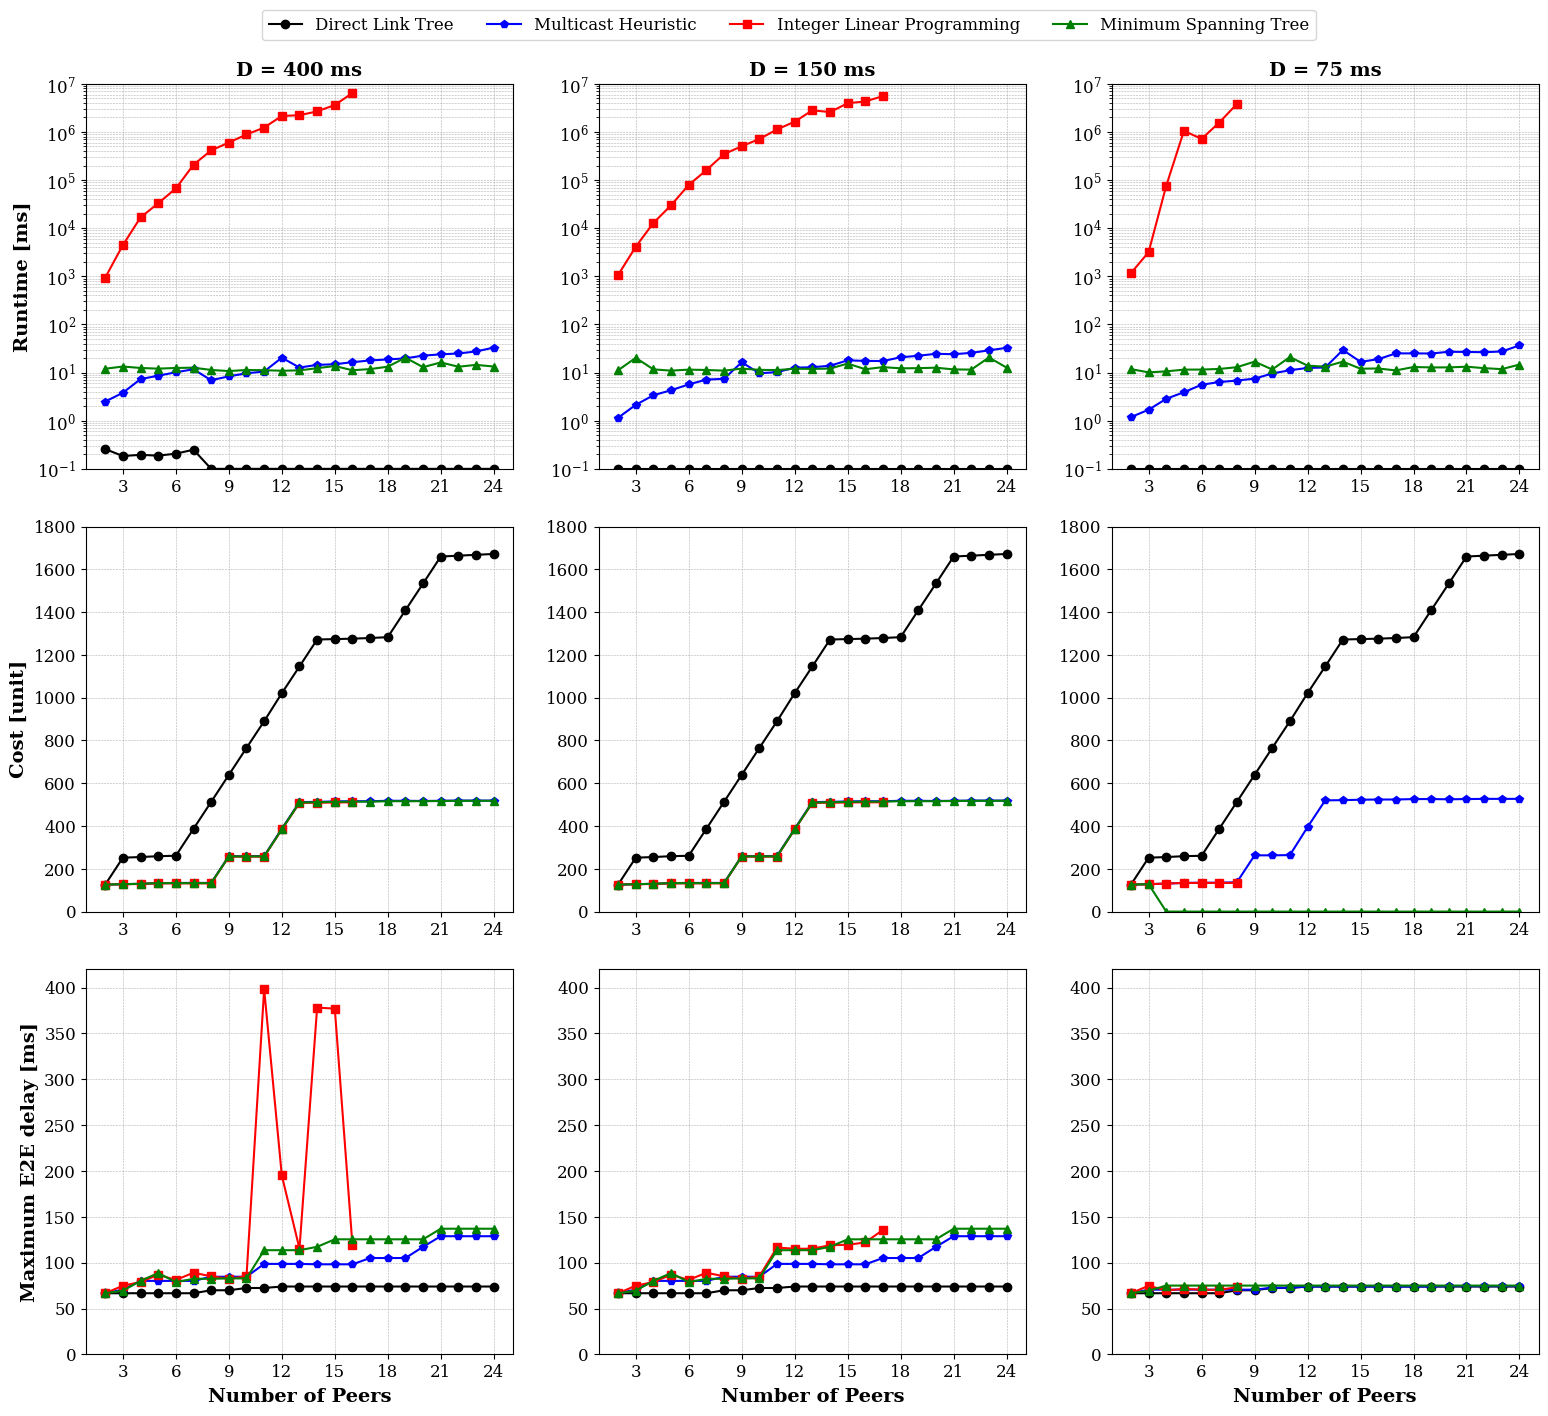

In [4]:
plot_runtime_vs_peers(opt_data_by_content)